In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import LlamaCPP, KeyBERTInspired
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from cuml.cluster import HDBSCAN
from cuml.manifold import UMAP
from bertopic import BERTopic
from llama_cpp import Llama
import pandas as pd
import re

In [33]:
# create custom stop words list
stop_words = list(set(stopwords.words('english')))
stop_words.extend(set(stopwords.words('french')))
stop_words.extend(set(stopwords.words('arabic'))) 
# add custom darija stop words
stop_words.extend(['هادشي','علاش','Machi', 'Gha', 'Dyal','chi','li','mn','3la','ana','wach','wla','bghit','bach','ila','rah','m3a','nta','ghir','dial','الله','راه','شي','ديال','هاد','او','ماشي','باش','انا','اللي','حاجة','ليا','عندي','ghadi','b7al','3liha','wakha','ba9i','3lih','3lik','3lach','liha','mazal','ليك','ال','الل','بلا','machi','dyal','kan','ra','howa','hadchi','lik','gha','walakin','daba'])

In [ ]:
# load comments
with open('../data/cleaned/comments.csv', 'r', encoding='utf-8') as file:
    comments_df = pd.read_csv(file, low_memory=False)
comments_df.fillna('', inplace=True)
comments_df.sort_values(by='created_utc', inplace=True, ignore_index=True)
comments = []
comments_df.body.apply(lambda x: comments.append(x))

In [ ]:
# load submissions
with open('../data/cleaned/submissions.csv', 'r', encoding='utf-8') as file:
    submissions = pd.read_csv(file)    
submissions.fillna('', inplace=True)
# drop rows where AutoModerator is the author
submissions = submissions[submissions['author'] != 'AutoModerator']
# concat title and selftext
submissions['body'] = submissions['title'] + ' ' + submissions['selftext']
submissions.sort_values(by='created_utc', inplace=True, ignore_index=True)
posts = []
submissions.body.apply(lambda x: posts.append(x))

In [ ]:
# define vectorizer_model
vectorizer_model = CountVectorizer(stop_words=stop_words, min_df=10, ngram_range=(1, 2))

# define umap_model and hdbscan_model for GPU acceleration
umap_model = UMAP(n_components=5, n_neighbors=15, min_dist=0.0)
hdbscan_model = HDBSCAN(min_samples=10, gen_min_span_tree=True, prediction_data=True)

In [ ]:
# Pre-calculated embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(posts + comments, show_progress_bar=True)

In [ ]:
# load Llama model for LLM representation
# wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf -P ../models 
llm = Llama(model_path="../models/zephyr-7b-alpha.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)

representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm),
}

topic_model = BERTopic(embedding_model=embedding_model, top_n_words=50, representation_model=representation_model, verbose=True, language="multilingual", vectorizer_model=vectorizer_model, umap_model=umap_model, hdbscan_model=hdbscan_model)

In [ ]:
topic_model.fit_transform(posts + comments, embeddings)

In [ ]:
topic_model.save("../models/bertopic-llama_model")

In [ ]:
topic_model = BERTopic.load("../models/bertopic-llama_model")

In [8]:
topic_model.visualize_topics(top_n_topics=200, title="Topics Visualization", height=800, width=1200)

In [9]:
topic_model.visualize_heatmap(top_n_topics=200, height=800, width=1200)

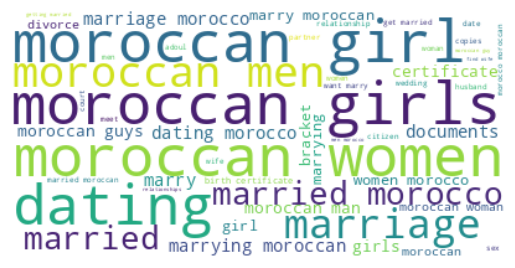

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=3)

## Map topic result to data and save it to a file

In [ ]:
submissions.drop(columns=['author', 'author_flair_text', 'title', 'selftext', 'link_flair_text', 'over_18', 'num_comments', 'hide_score'], inplace=True) 
comments_df.drop(columns=['author', 'author_flair_text', 'link_id', 'parent_id','score_hidden'], inplace=True)

# merge submissions and comments
submissions['type'] = 'submission'
comments_df['type'] = 'comment'
data = pd.concat([submissions, comments_df], ignore_index=True)

In [ ]:
topic_docs = topic_model.get_document_info(posts + comments)
topic_info = topic_model.get_topic_info()

In [ ]:
data = pd.concat([data, topic_docs], axis=1)
data.drop(columns=['Document','Name','Representation','KeyBERT','LLM','Representative_Docs','Top_n_words','Representative_document'], inplace=True)

In [ ]:
data.to_csv('../data/results/data.csv', index=False)

In [ ]:
topic_info = topic_model.get_topic_info()

In [ ]:
# perform some cleaning on the LLM column
topic_info['LLM'] = topic_info['LLM'].str[0]
topic_info['LLM'] = topic_info['LLM'].apply(lambda x: re.sub(r'Explanation:.*', '', x, flags=re.DOTALL).strip())
topic_info['LLM'] = topic_info['LLM'].apply(lambda x: re.sub(r'\(note.*', '', x, flags=re.DOTALL).strip())
topic_info['LLM'] = topic_info['LLM'].apply(lambda x: re.sub(r'"', '', x))
topic_info['LLM'] = topic_info['LLM'].apply(lambda x: re.sub(r' \'', '', x))
topic_info['LLM'] = topic_info['LLM'].apply(lambda x: re.sub(r'\' ', '', x))
#....
# more cleaning if needed


In [ ]:
topic_info.to_csv('../data/results/topic_info_cleaned.csv', index=False)